<a href="https://colab.research.google.com/github/SergeiVKalinin/ML-ElectronMicroscopy-2023/blob/main/Lecture%2017/3_0_crVAE_cards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   This notebook takes you through the application of rotationally invariant conditional variational autoencoder (crVAE) on four different cards datasets and the results analysis.  
*   Each cards dataset if formed by applying a random rotation and shear to the images of the cards. The datasets differ in the limits used for picking the rotations and shear.

*   conditional autoencoder conditions the encoding-decoding of each image on its ground truth class.
*   So, we form m independent latent spaces for a given dataset, where m is the number of classes present in the dataset
*   On top of this cVAE (from pyroved) can also be used to condition the encodings on a continuous ground truth property associated with each data point. This is not discussed in this notebook.
*   rVAE comprises of an additional latent dimension to the regular VAE, which explicitly captures the rotations involved in the image.
*   This angular latent dimension is unsupervisedly learned while trying to reconstuct the original image.
*   Like in VAE, this latent dimension is also regularized using a prior.  

The crVAEs are defined and trained using a package called Pyroved (https://github.com/ziatdinovmax/pyroVED) which is built on top of Pyro probabilistic programming framework. Please feel free to write to valletisai.mani@gmail.com for further enquiries.

In [ ]:
# Installing Kornia and pyroved
!pip install -q kornia git+https://github.com/ziatdinovmax/pyroVED@main

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.1/628.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 22.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.


In [ ]:
# Importing necessary packages

import pyroved as pv
import kornia as K


import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3

tt = torch.tensor

In [ ]:
#@title Helper functions that apply afffine transformations to the dataset
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    !gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
    !unzip -o -qq cards.zip
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


import math
def transform_imgs(cards, **kwargs):
    np.random.seed(0)
    torch.manual_seed(0)

    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = (kwargs.get("shear"))
    if s is not None:
        s = math.radians(s)


    n_samples = kwargs.get("samples", 3000)
    n_samples_total = n_samples*4

    card1, card2, card3, card4 = cards[0], cards[1], cards[2], cards[3]

    card1 = card1[None, None].repeat_interleave(n_samples, dim = 0)
    card2 = card2[None, None].repeat_interleave(n_samples, dim = 0)
    card3 = card3[None, None].repeat_interleave(n_samples, dim = 0)
    card4 = card4[None, None].repeat_interleave(n_samples, dim = 0)

    cards_all = torch.cat((card1, card2, card3, card4), dim = 0)

    angles = tt(np.random.uniform(low = -a, high = a, size = [n_samples_total]))
    translations = tt(np.random.uniform(low = -t, high = t, size = [n_samples_total,1])).repeat_interleave(2, dim = 1)
    shears = tt(np.random.uniform(low = -s, high = s, size = [n_samples_total, 1])).repeat_interleave(2, dim = 1)

    transform = nn.Sequential(
        K.augmentation.CenterCrop((48, 48)),
        K.geometry.Affine(angle = angles, translation = translations,
                          shear = shears)
    )

    cards = transform(cards_all).squeeze().float()
    labels = torch.cat([torch.zeros(len(card1)), torch.ones(len(card2)),
                           2*torch.ones(len(card3)), 3*torch.ones(len(card4))])

    labels_onehot = pv.utils.to_onehot(labels.to(torch.int64), 4)
    return cards, labels_onehot, angles, translations, shears


def plot_manifolds(model):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

In [ ]:
# Downloading the cards dataset
!gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip -o -qq cards.zip

Here we make 4 different datasets using the above helper functions which are as follows:  
*  cards-i: low rotations (12 degrees) and low shear (1 degree)
*  cards-ii: low rotations (12 degrees) and high shear (20 degrees)
*  cards-iii: high rotations (120 degrees) and low shear (1 degree)
*  cards-iv: high rotations (120 degrees) and high shear (20 degrees)

In [ ]:
# We save the ground truth labels for crVAE
# And the ground truth values of the transformations applied to analyze the latent spaces.

cards = get_data()
cards_all1, labels_all1, angles_all1, translations_all1, shears_all1 = transform_imgs(cards, angle = 12, translation = 0.1, shear = 1, samples = 3000)
cards_all2, labels_all2, angles_all2, translations_all2, shears_all2 = transform_imgs(cards, angle = 12, translation = 0.1, shear = 20, samples = 3000)
cards_all3, labels_all3, angles_all3, translations_all3, shears_all3 = transform_imgs(cards, angle = 120, translation = 0.1, shear = 1, samples = 3000)
cards_all4, labels_all4, angles_all4, translations_all4, shears_all4 = transform_imgs(cards, angle = 120, translation = 0.1, shear = 20, samples = 3000)

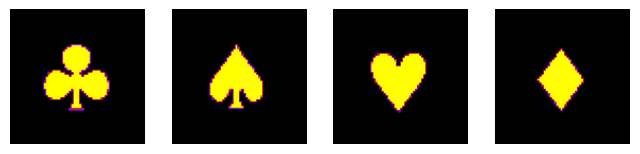

In [ ]:
# Visualizing the cards before applying transformations
fig, ax = plt.subplots(ncols = 4, figsize = (8,2))
for i in range(4):
    ax[i].imshow(cards[i], cmap = 'gnuplot')
    ax[i].axis('off')

# Training
*   Here we train one model of crVAE per dataset and save the weights.
*   One can skip this section to save time.
*   These weights will be loaded into the notebook in the next section to make it time-efficient

In [ ]:
#Train Loaders, unlike the rVAE, here the labels are also a part of the trainloader

# None corresponds to adding a dummy channel dimension to the dataset
train_loader1 = pv.utils.init_dataloader(cards_all1[:, None], labels_all1, batch_size=50)   #cards-i
train_loader2 = pv.utils.init_dataloader(cards_all2[:, None], labels_all2, batch_size=50)   #cards-ii
train_loader3 = pv.utils.init_dataloader(cards_all3[:, None], labels_all3, batch_size=50)   #cards-iii
train_loader4 = pv.utils.init_dataloader(cards_all4[:, None], labels_all4, batch_size=50)   #cards-iv

In [ ]:
# Training the crVAE1 on cards-i

in_dim = (48, 48)   # Input dimensions of the dataset i.e., shape of each card's image

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
crvae1 = pv.models.iVAE(in_dim, latent_dim=2,    # Number of latent dimensions other than the invariancies and class labels
                        c_dim = 4,   # Corresponds to the number of discrete classes in the dataset, these get concatenated to the encoder and decoder automatically
                      hidden_dim_e = [256,256],   # corresponds to the number of neurons in the hidden layers of the encoder
                     hidden_dim_d = [256,256],    # corresponds to the number of neurons in the hidden layers of the decoder
                     invariances=['r'], seed=0)

# Initialize SVI trainer
trainer1 = pv.trainers.SVItrainer(crvae1)
# Train for n epochs:
for e in range(100):
    trainer1.step(train_loader1)
    trainer1.print_statistics()

# Saving the weights of the trained crVAE1 model on cards-i
crvae1.save_weights('/content/drive/MyDrive/VAE Review/crvae_files/crave1')

Epoch: 1 Training loss: 532.9758
Epoch: 2 Training loss: 235.5862
Epoch: 3 Training loss: 181.7076
Epoch: 4 Training loss: 141.4826
Epoch: 5 Training loss: 124.5735
Epoch: 6 Training loss: 114.4570
Epoch: 7 Training loss: 107.5991
Epoch: 8 Training loss: 102.7164
Epoch: 9 Training loss: 99.2995
Epoch: 10 Training loss: 95.9591
Epoch: 11 Training loss: 94.4574
Epoch: 12 Training loss: 94.1248
Epoch: 13 Training loss: 91.4784
Epoch: 14 Training loss: 89.9675
Epoch: 15 Training loss: 90.0478
Epoch: 16 Training loss: 88.4633
Epoch: 17 Training loss: 87.0561
Epoch: 18 Training loss: 86.8243
Epoch: 19 Training loss: 85.4625
Epoch: 20 Training loss: 85.3742
Epoch: 21 Training loss: 85.0257
Epoch: 22 Training loss: 84.6261
Epoch: 23 Training loss: 85.7041
Epoch: 24 Training loss: 83.1370
Epoch: 25 Training loss: 83.6706
Epoch: 26 Training loss: 84.2428
Epoch: 27 Training loss: 82.9594
Epoch: 28 Training loss: 82.9336
Epoch: 29 Training loss: 81.9363
Epoch: 30 Training loss: 81.7262
Epoch: 31 T

RuntimeError: ignored

In [ ]:
# Training the crVAE2 on cards-ii

in_dim = (48, 48)   # Input dimensions of the dataset i.e., shape of each card's image


# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
crvae2 = pv.models.iVAE(in_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies and class labels
                        c_dim = 4,   # Corresponds to the number of discrete classes in the dataset, these get concatenated to the encoder and decoder automatically
                      hidden_dim_e = [256,256],   # corresponds to the number of neurons in the hidden layers of the encoder
                     hidden_dim_d = [256,256],   # corresponds to the number of neurons in the hidden layers of the decoder
                     invariances=['r'], seed=0)

# Initialize SVI trainer
trainer2 = pv.trainers.SVItrainer(crvae2)
# Train for n epochs:
for e in range(100):
    trainer2.step(train_loader2)
    trainer2.print_statistics()

# Saving the weights of the trained crVAE2 model on cards-ii
# crvae2.save_weights('/content/drive/MyDrive/VAE Review/crvae_files/crave2')

Epoch: 1 Training loss: 588.7591
Epoch: 2 Training loss: 328.4248
Epoch: 3 Training loss: 248.1311
Epoch: 4 Training loss: 203.8312
Epoch: 5 Training loss: 170.5263
Epoch: 6 Training loss: 148.5587
Epoch: 7 Training loss: 135.8697
Epoch: 8 Training loss: 133.2234
Epoch: 9 Training loss: 123.8817
Epoch: 10 Training loss: 124.9711
Epoch: 11 Training loss: 117.1617
Epoch: 12 Training loss: 117.8607
Epoch: 13 Training loss: 111.1267
Epoch: 14 Training loss: 112.4652
Epoch: 15 Training loss: 107.4927
Epoch: 16 Training loss: 114.0145
Epoch: 17 Training loss: 103.7819
Epoch: 18 Training loss: 105.4050
Epoch: 19 Training loss: 102.4699
Epoch: 20 Training loss: 102.7087
Epoch: 21 Training loss: 104.3618
Epoch: 22 Training loss: 100.4642
Epoch: 23 Training loss: 100.0843
Epoch: 24 Training loss: 103.4682
Epoch: 25 Training loss: 98.7285
Epoch: 26 Training loss: 99.0776
Epoch: 27 Training loss: 100.0739
Epoch: 28 Training loss: 97.5046
Epoch: 29 Training loss: 98.1350
Epoch: 30 Training loss: 10

In [ ]:
# Training the crVAE3 on cards-iii
in_dim = (48, 48)   # Input dimensions of the dataset i.e., shape of each card's image

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
crvae3 = pv.models.iVAE(in_dim, latent_dim=2, # Number of latent dimensions other than the invariancies
                        c_dim = 4,   # Corresponds to the number of discrete classes in the dataset, these get concatenated to the encoder and decoder automatically
                        hidden_dim_e = [256,256],   # corresponds to the number of neurons in the hidden layers of the encoder
                        hidden_dim_d = [256,256],   # corresponds to the number of neurons in the hidden layers of the decoder
                        invariances=['r'], seed=5)

# Initialize SVI trainer
trainer3 = pv.trainers.SVItrainer(crvae3)
# Train for n epochs:
for e in range(100):
    trainer3.step(train_loader3)
    trainer3.print_statistics()
# Saving the weights of the trained crVAE3 model on cards-iii
#crvae3.save_weights('/content/drive/MyDrive/VAE Review/crvae_files/crave3')

In [ ]:
# Training the rVAE on cards-iv
in_dim = (48, 48)   # Input dimensions of the dataset i.e., shape of each card's image


# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
crvae4 = pv.models.iVAE(in_dim, latent_dim=2, # Number of latent dimensions other than the invariancies
                        c_dim = 4,   # Corresponds to the number of discrete classes in the dataset, these get concatenated to the encoder and decoder automatically
                        hidden_dim_e = [256,256],   # corresponds to the number of neurons in the hidden layers of the encoder
                        hidden_dim_d = [256,256],   # corresponds to the number of neurons in the hidden layers of the decoder
                        invariances=['r'], seed=0)

# Initialize SVI trainer
trainer4 = pv.trainers.SVItrainer(crvae4)
# Train for n epochs:
for e in range(100):
    trainer4.step(train_loader4)
    trainer4.print_statistics()
# Saving the weights of the trained crVAE4 model on cards-iv
# crvae4.save_weights('/content/drive/MyDrive/VAE Review/crvae_files/crave4')

# Visulizing the results
Saved weights will be downloaded in the corresponding sections

## cards-i
Low rotation (12 deg) and low shear (1 deg)

In [ ]:
# First let's just visualize some randomly picked samples from the input dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all1))
    ax.imshow(cards_all1[i], cmap='gnuplot', interpolation='nearest')

In [ ]:
# Initializing a new network
in_dim = (48,48)
crvae1 = pv.models.iVAE(in_dim, latent_dim=2, c_dim = 4,
                      hidden_dim_e = [256,256],
                     hidden_dim_d = [256,256],
                     invariances=['r'], seed=1)
# Download the weigths file
!gdown 1h2BRSRhT21e5R-AO1c5MeJYLKgNhMs-Y

# Loading the saved weights into the newly initialized network
crvae1.load_weights('crvae1.pt')

In [ ]:
# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions.
# These points are decoded back into the image space and are plotted in their corresponding latent space positions
# Since the latent space of crVAE is conditioned on the class label, we get one latent space for each class

for cls in range(4):
    cls = pv.utils.to_onehot(tt([cls,]), 4)
    crvae1.manifold2d(d=9, y=cls, cmap="gnuplot")   # d corresponds to the number of points sampled in each latent dimension

Latent Distributions:  
Input images are represented as points in the latent space using the encoder  
These points are then colored with various ground-truth properties to visualize their distribution

In [ ]:
targets_all1 = torch.argmax(labels_all1, dim = 1)  # Obtaining the classes from one-hot encoded vectors
z_mean1, z_sd1 = crvae1.encode(cards_all1[:, None], labels_all1)# Encoding the full input dataset
# z_mean1: mean of the latent space representation of the input dataset,
# z_sd1: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions)


# Latent distribution colored using the suit of each image
fig, ax = plt.subplots(1, 1, figsize =(7, 6))
im = ax.scatter(z_mean1[:,-1], z_mean1[:,-2], c=targets_all1, s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.show()

# It should be noted that each suit (color) lives in an independent latent space from the other suits (colors)

Since the latent space of each suit is independent, we plot the latent distributions in four different latent spaces corresponding to their suit

In [ ]:
# Latent distribution colored using the ground truth shear applied on each image

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (7,7))

inds = np.zeros([len(targets_all1), 4], dtype = bool)
for i in range(4):
    inds[:, i] = np.asarray(targets_all1 == i, dtype = bool)

ax[0,0].scatter(z_mean1[inds[:,0], -1], z_mean1[inds[:,0],-2], c=shears_all1[inds[:,0],0], s=1, cmap='jet')
ax[0,0].set_xlabel("$z_1$", fontsize=14)
ax[0,0].set_ylabel("$z_2$", fontsize=14)

ax[0,1].scatter(z_mean1[inds[:,1], -1], z_mean1[inds[:,1],-2], c=shears_all1[inds[:,1],0], s=1, cmap='jet')
ax[0,1].set_xlabel("$z_1$", fontsize=14)
ax[0,1].set_ylabel("$z_2$", fontsize=14)

ax[1,0].scatter(z_mean1[inds[:,2], -1], z_mean1[inds[:,2],-2], c=shears_all1[inds[:,2],0], s=1, cmap='jet')
ax[1,0].set_xlabel("$z_1$", fontsize=14)
ax[1,0].set_ylabel("$z_2$", fontsize=14)

ax[1,1].scatter(z_mean1[inds[:,3], -1], z_mean1[inds[:,3],-2], c=shears_all1[inds[:,3],0], s=1, cmap='jet')
ax[1,1].set_xlabel("$z_1$", fontsize=14)
ax[1,1].set_ylabel("$z_2$", fontsize=14)



In [ ]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images.
# The points are colored using the suit of the images.

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(torch.deg2rad(angles_all1), z_mean1[:,0], c = targets_all1, s =1, cmap = 'jet')

## cards-ii
Low rotation (12 deg) High shear (20deg)

In [ ]:
# First let's just visualize some randomly picked samples from the input dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all2))
    ax.imshow(cards_all2[i], cmap='gnuplot', interpolation='nearest')

In [ ]:
# Initializing a new network
in_dim = (48, 48)
crvae2 = pv.models.iVAE(in_dim, latent_dim=2, c_dim = 4,
                      hidden_dim_e = [256,256],
                     hidden_dim_d = [256,256],
                     invariances=['r'], seed=1)

# Download the weigths file
!gdown 1--OtYXcmrGaIaMZNQIVj-QjevZcW80CD

# Loading the saved weights into the newly initialized network
crvae2.load_weights('crvae2.pt')

In [ ]:
# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions.
# These points are decoded back into the image space and are plotted in their corresponding latent space positions
# Since the latent space of crVAE is conditioned on the class label, we get one latent space for each class

for cls in range(4):
    cls = pv.utils.to_onehot(tt([cls,]), 4)
    crvae2.manifold2d(d=9, y=cls, cmap="viridis")  # d corresponds to the number of points sampled in each latent dimension

Latent Distributions:  
Input images are represented as points in the latent space using the encoder  
These points are then colored with various ground-truth properties to visualize their distribution

In [ ]:
targets_all2 = torch.argmax(labels_all2, dim = 1)   # Obtaining the classes from one-hot encoded vectors
z_mean2, z_sd2 = crvae2.encode(cards_all2[:, None], labels_all2)   # Encoding the full input dataset
# z_mean1: mean of the latent space representation of the input dataset,
# z_sd1: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions)

# Latent distribution colored using the suit of each image
fig, ax = plt.subplots(1, 1, figsize =(7, 6))
im = ax.scatter(z_mean2[:,-1], z_mean2[:,-2], c=targets_all2, s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.show()

# It should be noted that each suit (color) lives in an independent latent space from the other suits (colors)

Since the latent space of each suit is independent, we plot the latent distributions in four different latent spaces corresponding to their suit

In [ ]:
# Latent distribution colored using the ground-truth shear of each image

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (7,7))

inds = np.zeros([len(targets_all2), 4], dtype = bool)
for i in range(4):
    inds[:, i] = np.asarray(targets_all2 == i, dtype = bool)

ax[0,0].scatter(z_mean2[inds[:,0], -1], z_mean2[inds[:,0],-2], c=shears_all2[inds[:,0],0], s=1, cmap='jet')
ax[0,0].set_xlabel("$z_1$", fontsize=14)
ax[0,0].set_ylabel("$z_2$", fontsize=14)

ax[0,1].scatter(z_mean2[inds[:,1], -1], z_mean2[inds[:,1],-2], c=shears_all2[inds[:,1],0], s=1, cmap='jet')
ax[0,1].set_xlabel("$z_1$", fontsize=14)
ax[0,1].set_ylabel("$z_2$", fontsize=14)

ax[1,0].scatter(z_mean2[inds[:,2], -1], z_mean2[inds[:,2],-2], c=shears_all2[inds[:,2],0], s=1, cmap='jet')
ax[1,0].set_xlabel("$z_1$", fontsize=14)
ax[1,0].set_ylabel("$z_2$", fontsize=14)

ax[1,1].scatter(z_mean2[inds[:,3], -1], z_mean2[inds[:,3],-2], c=shears_all2[inds[:,3],0], s=1, cmap='jet')
ax[1,1].set_xlabel("$z_1$", fontsize=14)
ax[1,1].set_ylabel("$z_2$", fontsize=14)

In [ ]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images.
# The points are colored using the suit of the images.

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(torch.deg2rad(angles_all2), z_mean2[:,0], c = targets_all2, s =1, cmap = 'jet')

## cards-iii
High rotation (120 degrees) and Low shear (1 degree)

In [ ]:
# First let's just visualize some randomly picked samples from the input dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all3))
    ax.imshow(cards_all3[i], cmap='gnuplot', interpolation='nearest')

In [ ]:
# Initializing a new network
in_dim = (48,48)
crvae3 = pv.models.iVAE(in_dim, latent_dim=2, c_dim = 4,
                      hidden_dim_e = [256,256],
                     hidden_dim_d = [256,256],
                     invariances=['r'], seed=1)
# Download the weigths file
!gdown 1-FSNB55Wwo7T6qeh-gFjAdvjEUu38coq

# Loading the saved weights into the newly initialized network
crvae3.load_weights('crvae3.pt')

In [ ]:
# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions.
# These points are decoded back into the image space and are plotted in their corresponding latent space positions
# Since the latent space of crVAE is conditioned on the class label, we get one latent space for each class

for cls in range(4):
    cls = pv.utils.to_onehot(tt([cls,]), 4)
    crvae3.manifold2d(d=9, y=cls, cmap="viridis")

Latent Distributions:  
Input images are represented as points in the latent space using the encoder  
These points are then colored with various ground-truth properties to visualize their distribution

In [ ]:
targets_all3 = torch.argmax(labels_all3, dim = 1)   # Obtaining the classes from one-hot encoded vectors
z_mean3, z_sd3 = crvae3.encode(cards_all3[:, None], labels_all3)   # Encoding the full input dataset
# z_mean1: mean of the latent space representation of the input dataset,
# z_sd1: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions)


# Latent distribution colored using the suit of each image
fig, ax = plt.subplots(1, 1, figsize =(7, 6))
im = ax.scatter(z_mean3[:,-1], z_mean3[:,-2], c=targets_all3, s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.show()
# It should be noted that each suit (color) lives in an independent latent space from the other suits (colors)

Since the latent space of each suit is independent, we plot the latent distributions in four different latent spaces corresponding to their suit

In [ ]:
# Latent distribution colored using the ground-truth shear of each image
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (7,7))

inds = np.zeros([len(targets_all3), 4], dtype = bool)
for i in range(4):
    inds[:, i] = np.asarray(targets_all3 == i, dtype = bool)

ax[0,0].scatter(z_mean3[inds[:,0], -1], z_mean3[inds[:,0],-2], c=shears_all3[inds[:,0],0], s=1, cmap='jet')
ax[0,0].set_xlabel("$z_1$", fontsize=14)
ax[0,0].set_ylabel("$z_2$", fontsize=14)

ax[0,1].scatter(z_mean3[inds[:,1], -1], z_mean3[inds[:,1],-2], c=shears_all3[inds[:,1],0], s=1, cmap='jet')
ax[0,1].set_xlabel("$z_1$", fontsize=14)
ax[0,1].set_ylabel("$z_2$", fontsize=14)

ax[1,0].scatter(z_mean3[inds[:,2], -1], z_mean3[inds[:,2],-2], c=shears_all3[inds[:,2],0], s=1, cmap='jet')
ax[1,0].set_xlabel("$z_1$", fontsize=14)
ax[1,0].set_ylabel("$z_2$", fontsize=14)

ax[1,1].scatter(z_mean3[inds[:,3], -1], z_mean3[inds[:,3],-2], c=shears_all3[inds[:,3],0], s=1, cmap='jet')
ax[1,1].set_xlabel("$z_1$", fontsize=14)
ax[1,1].set_ylabel("$z_2$", fontsize=14)

In [ ]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images.
# The points are colored using the suit of the images.

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(torch.deg2rad(angles_all3), z_mean3[:,0], c = targets_all3, s =25, cmap = 'jet')
ax.set_xlabel("ground truth", fontsize=14)
ax.set_ylabel("angular encoding", fontsize=14)

## cards-iv
High rotation (120 degrees) and high shear (20 degrees)

In [ ]:
# First let's just visualize some randomly picked samples from the input dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all4))
    ax.imshow(cards_all4[i], cmap='gnuplot', interpolation='nearest')

In [ ]:
# Initializing a new network
in_dim = (48,48)
crvae4 = pv.models.iVAE(in_dim, latent_dim=2, c_dim = 4,
                      hidden_dim_e = [256,256],
                     hidden_dim_d = [256,256],
                     invariances=['r'], seed=1)

# Download the weigths file
!gdown 1-LeIFSUxBWRgUZMgCnrlaDW8fqlkN_E6

# Loading the saved weights into the newly initialized network
crvae4.load_weights('crvae4.pt')

In [ ]:
# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions.
# These points are decoded back into the image space and are plotted in their corresponding latent space positions
# Since the latent space of crVAE is conditioned on the class label, we get one latent space for each class

for cls in range(4):
    cls = pv.utils.to_onehot(tt([cls,]), 4)
    crvae4.manifold2d(d=9, y=cls, cmap="viridis")   # d corresponds to the number of points sampled in each latent dimension

Latent Distributions:  
Input images are represented as points in the latent space using the encoder  
These points are then colored with various ground-truth properties to visualize their distribution

In [ ]:
targets_all4 = torch.argmax(labels_all4, dim = 1)   # Obtaining the classes from one-hot encoded vectors
z_mean4, z_sd4 = crvae4.encode(cards_all4[:, None], labels_all4)   # Encoding the full input dataset
# z_mean1: mean of the latent space representation of the input dataset,
# z_sd1: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions)


# Latent distribution colored using the suit of each image
fig, ax = plt.subplots(1, 1, figsize =(5, 5))
im = ax.scatter(z_mean4[:,-1], z_mean4[:,-2], c=targets_all4, s=10, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)

# plt.savefig('crvae_case4_latent_dis.png', dpi = 300)
plt.show()

# It should be noted that each suit (color) lives in an independent latent space from the other suits (colors)

Since the latent space of each suit is independent, we plot the latent distributions in four different latent spaces corresponding to their suit

In [ ]:
# Latent distribution colored using the ground truth shear of each image
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (7,7))

inds = np.zeros([len(targets_all4), 4], dtype = bool)
for i in range(4):
    inds[:, i] = np.asarray(targets_all4 == i, dtype = bool)

ax[0,0].scatter(z_mean4[inds[:,0], -1], z_mean4[inds[:,0],-2], c=shears_all4[inds[:,0],0], s=1, cmap='jet')
ax[0,0].set_xlabel("$z_1$", fontsize=14)
ax[0,0].set_ylabel("$z_2$", fontsize=14)

ax[0,1].scatter(z_mean4[inds[:,1], -1], z_mean4[inds[:,1],-2], c=shears_all4[inds[:,1],0], s=1, cmap='jet')
ax[0,1].set_xlabel("$z_1$", fontsize=14)
ax[0,1].set_ylabel("$z_2$", fontsize=14)

ax[1,0].scatter(z_mean4[inds[:,2], -1], z_mean4[inds[:,2],-2], c=shears_all4[inds[:,2],0], s=1, cmap='jet')
ax[1,0].set_xlabel("$z_1$", fontsize=14)
ax[1,0].set_ylabel("$z_2$", fontsize=14)

ax[1,1].scatter(z_mean4[inds[:,3], -1], z_mean4[inds[:,3],-2], c=shears_all4[inds[:,3],0], s=1, cmap='jet')
ax[1,1].set_xlabel("$z_1$", fontsize=14)
ax[1,1].set_ylabel("$z_2$", fontsize=14)

In [ ]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images.
# The points are colored using the suit of the images.

fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(torch.deg2rad(angles_all4), z_mean4[:,0], c = targets_all4, s =25, cmap = 'jet')
ax.set_xlabel("ground truth", fontsize=14)
ax.set_ylabel("angular encoding", fontsize=14)
# plt.savefig('crvae_case4_angle_plot.png', dpi = 300)